# 🫀 Heart Disease Prediction and Interpretability

This notebook demonstrates a complete machine learning pipeline applied to the UCI Heart Disease dataset. All models and tools are implemented from scratch, including:

- Logistic Regression
- Decision Tree
- Random Forest
- LIME (Local Interpretable Model-Agnostic Explanations)

The goal is both predictive performance and interpretability — understanding **why** the model made a prediction.


## 🔧 Setup and Imports

We begin by importing all required modules from our custom `courselib` framework.

In [1]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from matplotlib import pyplot as plt

# Custom modules (all implemented from scratch)
from courselib.utils.loaders import load_heart_data
from courselib.utils.preprocessing import preprocess_dataframe
from courselib.utils.normalization import minmax_normalize
from courselib.utils.splits import train_test_split
from courselib.utils.metrics import accuracy, f1_score, mean_squared_error, binary_accuracy
from courselib.models.logistic import LogisticRegression
from courselib.models.tree import DecisionTree
from courselib.models.forest import RandomForest
from courselib.optimizers import GDOptimizer
from courselib.explain.lime import LimeTabularExplainer

## 📥 Load and Preprocess Data

We use the UCI Heart Disease dataset, which includes patient data (e.g. age, sex, cholesterol, etc.) and a target variable indicating presence (1-4) or absence (0) of heart disease (Source: https://archive.ics.uci.edu/dataset/45/heart+disease). 

> ### 💡 Binary Transformation
>
> The target ranges from 0 to 4:
> - 0 = no presence of heart disease
> - 1–4 = presence of heart disease  
>  
> Our research focuses on the binary classification task: **presence (1–4) vs. absence (0)** as described in the dataset information.
> So we convert:
>
> $$
> y = \begin{cases}
>     0 & \text{if } y = 0 \\\\
>     1 & \text{if } y \in \{1, 2, 3, 4\}
> \end{cases}
> $$

Steps:
- Fetch dataset
- Convert multiclass to binary target
- Encode categorical features
- Normalize numerical features to [0, 1] range
- Split into training and testing sets


In [2]:
# Load raw data
X_df, y_series = load_heart_data()

# Convert target to binary: 0 (no disease), 1 (disease)
y_series = (y_series > 0).astype(int)

# Combine and preprocess
X, y = preprocess_dataframe(pd.concat([X_df, y_series], axis=1), target_col= "num")

# Normalize features
X = minmax_normalize(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=42)
print('Training data split as follows:')
print(f'  Training data samples: {len(X_train)}')
print(f'      Test data samples: {len(X_test)}')


🧼 Dropping rows with missing values:
  - ca: 4 missing
  - thal: 2 missing
❌ Total rows dropped: 6
Training data split as follows:
  Training data samples: 237
      Test data samples: 60


## 📈 Logistic Regression

We implement logistic regression using gradient descent.

> ### 💡 Model and Loss
>
> The model computes probabilities as:
>
> $$
> \hat{y}_i = \sigma(w^T x_i + b), \quad \text{where} \quad \sigma(z) = \frac{1}{1 + e^{-z}}
> $$
>
> The loss function is binary cross-entropy:
>
> $$
> \mathcal{L}(w, b) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
> $$
>
> Optimized using gradient descent.


In [3]:
optimizer = GDOptimizer(learning_rate=1e-1)
logreg = LogisticRegression(
    w=np.zeros(X_train.shape[1]), 
    b=0.0, 
    optimizer=optimizer
)
logreg.fit(X_train, y_train, num_epochs=50)

y_pred_logreg = logreg(X_test)
print("Logistic Regression Accuracy:", accuracy(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.7666666666666667


In [ ]:
optimizer = GDOptimizer(learning_rate=1e-1)
logreg = LogisticRegression(
    w=np.zeros(X_train.shape[1]), 
    b=0.0, 
    optimizer=optimizer, 
    penalty="none"
)

accuracy = lambda y_true,y_pred: binary_accuracy(y_true,y_pred,class_labels=[0,1])
metrics_dict = {'accuracy': accuracy,
                'MSE': mean_squared_error}
metrics_history = logreg.fit(X_train, y_train, num_epochs=5000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

y_pred_logreg = logreg(X_test)
print("Logistic Regression Accuracy:", accuracy(y_test, y_pred_logreg))


Logistic Regression Accuracy: 85.0


The final train accuracy: 85.23206751054853%
Test accuracy: 85.0%


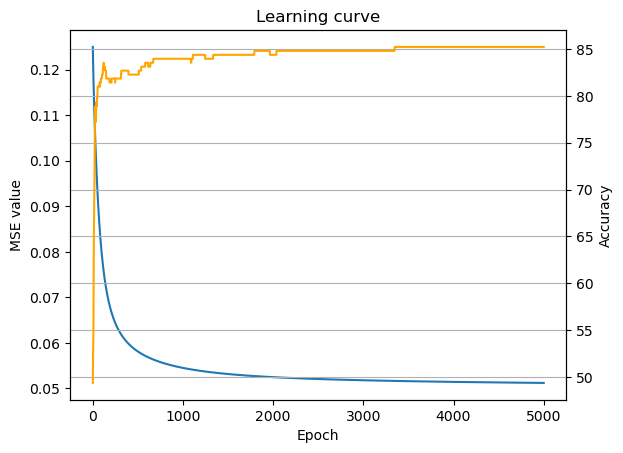

In [21]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'])
ax.set_ylabel('MSE value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {metrics_history["accuracy"][-1]}%')
print(f'Test accuracy: {accuracy(logreg(X_test), y_test)}%')

## 🌳 Decision Tree

Decision trees recursively split the data to reduce impurity and create interpretable decision rules.

> ### 💡 Impurity Measures
>
> Gini impurity:
> $$
> G = 1 - \sum_{k=1}^K p_k^2
> $$
>
> Entropy:
> $$
> H = -\sum_{k=1}^K p_k \log(p_k)
> $$
>
> A split is chosen to minimize weighted impurity.


In [32]:
tree = DecisionTree(max_depth=4)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print("Decision Tree Accuracy:", accuracy(y_test, y_pred_tree))


Decision Tree Accuracy: 0.7333333333333333


## 🌲 Random Forest

Random forests are ensembles of decision trees, trained on random subsets of the data and features.

> ### 💡 Key Idea
>
> Combine multiple weak learners (trees) to create a strong learner.
> Each tree votes, and the majority decision is the output.
>
> This improves generalization and reduces variance.


In [33]:
forest = RandomForest(n_estimators=50, max_depth=4)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)
print("Random Forest Accuracy:", accuracy(y_test, y_pred_forest))


Random Forest Accuracy: 0.8166666666666667


## 🔍 LIME: Model Interpretability

LIME explains individual predictions by approximating the model locally with a simpler interpretable model.

> ### 💡 How LIME Works
>
> 1. Sample points around the instance using noise
> 2. Get predictions from the black-box model
> 3. Fit a weighted linear model (e.g. ridge regression)
> 4. Interpret feature weights of this surrogate model


In [19]:
import numpy as np

# Assume: X_train, X_test, logreg, and LimeTabularExplainer are already defined

# 1. Check shape and validity of X_train
print("✅ X_train shape:", X_train.shape)
print("✅ Any NaNs in X_train?", np.isnan(X_train).any())

# 2. Initialize explainer and print internal stats
explainer = LimeTabularExplainer(X_train, feature_names=X_df.columns.tolist(), kernel_width=1.0)
print("✅ Feature std (min/max):", np.min(explainer.feature_std), np.max(explainer.feature_std))

# 3. Pick instance and generate perturbations manually
instance = X_test[5]
num_samples = 300
perturbed = np.random.normal(loc=instance, scale=explainer.feature_std, size=(num_samples, len(instance)))
perturbed = np.clip(perturbed, 0, 1)
perturbed = np.vstack([instance, perturbed])

print("✅ Perturbed shape:", perturbed.shape)
print("✅ Perturbed sample stats [first row]:", perturbed[0])

# 4. Run model predictions
predict_fn = lambda x: logreg.decision_function(np.atleast_2d(x)).flatten()
preds = predict_fn(perturbed)
print("✅ Predictions shape:", preds.shape)
print("✅ Prediction stats:", np.min(preds), np.max(preds), np.unique(preds[:10]))

# 5. Compute distances and sample weights
distances = np.linalg.norm((perturbed - instance) / explainer.feature_std, axis=1)
weights = np.exp(-distances ** 2 / explainer.kernel_width ** 2)
print("✅ Sample weights stats:", np.min(weights), np.max(weights), np.mean(weights))

# 6. Test RidgeRegression stability
from courselib.models.ridge import RidgeRegression
ridge = RidgeRegression(alpha=1.0, fit_intercept=True)
try:
    ridge.fit(perturbed, preds, sample_weight=weights)
    print("✅ Ridge fit: success")
    print("✅ Coef preview:", ridge.coef_[:5])
except Exception as e:
    print("❌ Ridge fit error:", e)


✅ X_train shape: (237, 13)
✅ Any NaNs in X_train? False
✅ Feature std (min/max): 0.11310354958411033 0.49565040043363123
✅ Perturbed shape: (301, 13)
✅ Perturbed sample stats [first row]: [0.6875     0.         1.         0.41509434 0.38356164 1.
 0.         0.26717557 0.         0.30645161 0.5        1.
 0.        ]
✅ Predictions shape: (301,)
✅ Prediction stats: 0.5 0.5 [0.5]
✅ Sample weights stats: 4.783239439482704e-13 1.0 0.012453276065494245
✅ Ridge fit: success
✅ Coef preview: [-9.89834684e-16 -4.07641228e-17 -9.89822059e-16 -6.02966435e-16
 -3.46485774e-16]


In [22]:
logreg.fit(X_train, y_train, num_epochs=100)

In [23]:
print("Model weights:", logreg.w)
print("Bias:", logreg.b)

Model weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Bias: [0.]


In [20]:
explainer = LimeTabularExplainer(X_train, feature_names=X_df.columns.tolist())
instance = X_test[5]
predict_fn = lambda x: logreg.decision_function(np.atleast_2d(x)).flatten()
weights, idx = explainer.explain_instance(instance, predict_fn, num_samples=300)

print("Top LIME Features:")
for feat, w in explainer.as_list(weights, idx, top_k=5):
    print(f"{feat}: {w:.4f}")


Prediction stats: 0.5 0.5 [0.5]
Top LIME Features:
slope: -0.0000
ca: -0.0000
chol: -0.0000
fbs: -0.0000
oldpeak: -0.0000


In [19]:
print("Prediction stats:", np.min(preds), np.max(preds), np.unique(preds))


NameError: name 'preds' is not defined

## ✅ Summary

We implemented and interpreted multiple models from scratch:

- 🧮 Logistic Regression (with gradients and sigmoid)
- 🌳 Decision Tree (using impurity criteria)
- 🌲 Random Forest (ensemble of trees)
- 🔍 LIME (local explanations with RidgeRegression)

All within a modular framework designed for transparency and learning.
